# Image Segmentation | Retina Vessel Extraction | James Roberts 2020

In [1]:
import os
import cv2
import datetime

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from imageio import imread

from tensorflow.keras import Input, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, BatchNormalization, Dropout, Concatenate, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard

In [2]:
print("Version:", tf.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

Version: 1.15.0
GPU is available


### Define the model

In [3]:
compute_size = 1024

input_size=(compute_size, compute_size, 3)
start_neurons=16

In [4]:
def UNet():
    
    inputs = Input(input_size)
    
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    
    convm = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    convm = BatchNormalization()(convm)
    convm = Activation('relu')(convm)
    convm = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    convm = BatchNormalization()(convm)
    convm = Activation('relu')(convm)
    
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv3 = Concatenate()([deconv3, conv3])
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = BatchNormalization()(uconv3)
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Activation('relu')(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = BatchNormalization()(uconv3)
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Activation('relu')(uconv3)
    
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = Concatenate()([deconv2, conv2])
    
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = BatchNormalization()(uconv2)
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Activation('relu')(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = BatchNormalization()(uconv2)
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Activation('relu')(uconv2)
    
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = Concatenate()([deconv1, conv1])
    
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Activation('relu')(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Activation('relu')(uconv1)
    
    output_layer_noActi = Conv2D(1, (1, 1), padding="same", activation=None)(uconv1)
    output_layer = Activation('sigmoid')(output_layer_noActi)

    model = Model(inputs=inputs, outputs=output_layer)

    return model

In [5]:
model = UNet()
model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1024, 1024,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 1024, 1024, 1 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 1024, 1024, 1 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activa

### Prepare the dataset

In [6]:
data_location = '/mnt/vanguard/datasets/retina/CHASE/'
training_images_loc = data_location + 'train/images/'
training_label_loc = data_location + 'train/labels/'
validate_images_loc = data_location + 'validate/images/'
validate_label_loc = data_location + 'validate/labels/'

In [7]:
image_border = [0, 0, 0]
label_border = [0]

In [8]:
train_files = os.listdir(training_images_loc)
train_data = []
train_label = []

for i in train_files:
    image = imread(training_images_loc + i)
    label = imread(training_label_loc + i.split('_')[0]+"_"+i.split('_')[1].split(".")[0] +"_1stHO.png", pilmode="L")
    
    source_size = image.shape[:2]
    delta = max(source_size[0], source_size[1])
    
    delta_w = delta - source_size[1]
    delta_h = delta - source_size[0]
    
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)
    
    new_im = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=image_border)
    new_label = cv2.copyMakeBorder(label, top, bottom, left, right, cv2.BORDER_CONSTANT, value=label_border)
    
    train_data.append(cv2.resize(new_im, (compute_size, compute_size)))
    
    temp = cv2.resize(new_label, (compute_size, compute_size))
    _, temp = cv2.threshold(temp, 127, 255, cv2.THRESH_BINARY)
    
    train_label.append(temp)

In [9]:
validate_files = os.listdir(validate_images_loc)
validate_data = []
validate_label = []

for i in validate_files:
    image = imread(validate_images_loc + i)
    label = imread(validate_label_loc + i.split('_')[0]+"_"+i.split('_')[1].split(".")[0] +"_1stHO.png", pilmode="L")
    
    source_size = image.shape[:2]
    delta = max(source_size[0], source_size[1])
    
    delta_w = delta - source_size[1]
    delta_h = delta - source_size[0]
    
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)
    
    new_im = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=image_border)
    new_label = cv2.copyMakeBorder(label, top, bottom, left, right, cv2.BORDER_CONSTANT, value=label_border)
    
    validate_data.append(cv2.resize(new_im, (compute_size, compute_size)))
    
    temp = cv2.resize(new_label, (compute_size, compute_size))
    _, temp = cv2.threshold(temp, 127, 255, cv2.THRESH_BINARY)
    
    validate_label.append(temp)

In [10]:
train_data = np.array(train_data)
train_label = np.array(train_label)

x_train = train_data.astype('float32') / 255.0
y_train = train_label.astype('float32') / 255.0
x_train = np.reshape(x_train, (len(x_train), compute_size, compute_size, 3))
y_train = np.reshape(y_train, (len(y_train), compute_size, compute_size, 1))

In [11]:
validate_data = np.array(validate_data)
validate_label = np.array(validate_label)

x_validate = validate_data.astype('float32') / 255.0
y_validate = validate_label.astype('float32') / 255.0
x_validate = np.reshape(x_validate, (len(x_validate), compute_size, compute_size, 3))
y_validate = np.reshape(y_validate, (len(y_validate), compute_size, compute_size, 1))

In [12]:
print("x_train.shape = {}".format(x_train.shape))
print("y_train.shape = {}".format(y_train.shape))

x_train.shape = (247, 1024, 1024, 3)
y_train.shape = (247, 1024, 1024, 1)


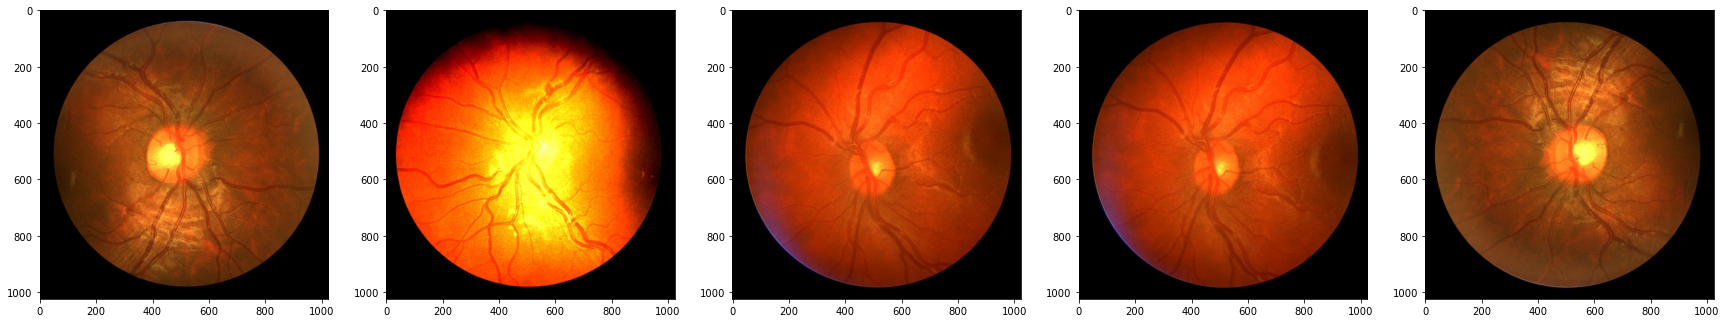

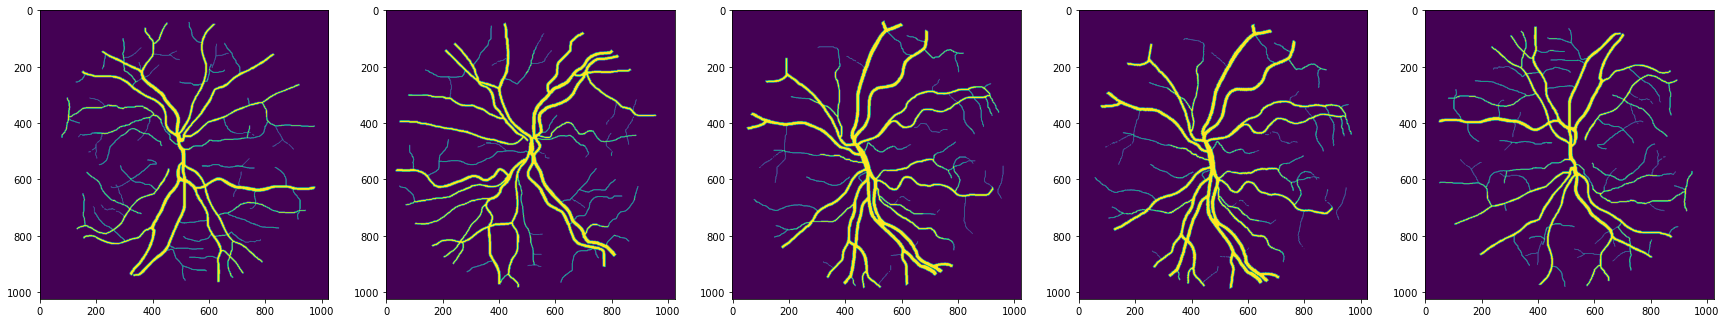

In [13]:
nplot = 5

fig = plt.figure(figsize=(30,10))
for count in range(1,nplot+1):
    ax = fig.add_subplot(1,nplot,count)
    ax.imshow(x_train[count])
    
fig = plt.figure(figsize=(30,10))
for count in range(1,nplot+1):
    ax = fig.add_subplot(1,nplot,count)
    ax.imshow(y_train[count])
    
plt.show()

# Train

In [14]:
OUTDIR = '/mnt/vanguard/lab/SA-UNet/work/training_loop/'
log_dir = OUTDIR + 'logs/'
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [15]:
# Enable Tensorboard port
command = "tensorboard --logdir=" + str(log_dir) + " --port=6006 &"
os.system(command)

0

In [16]:
history=model.fit(x_train, y_train,
                epochs=10,
                batch_size=4,
                validation_data=(x_validate, y_validate),
                shuffle=True,
                callbacks = [TensorBoard(log_dir=log_dir + "fit/" + timestamp)])

Train on 247 samples, validate on 13 samples
Epoch 1/10
247/247 [==============================] - 49s 197ms/sample - loss: 0.4854 - acc: 0.8505 - val_loss: 0.4291 - val_acc: 0.9254
Epoch 2/10
247/247 [==============================] - 34s 138ms/sample - loss: 0.3390 - acc: 0.9235 - val_loss: 0.3095 - val_acc: 0.9254
Epoch 3/10
247/247 [==============================] - 35s 140ms/sample - loss: 0.3038 - acc: 0.9290 - val_loss: 0.2665 - val_acc: 0.9254
Epoch 4/10
247/247 [==============================] - 35s 140ms/sample - loss: 0.2688 - acc: 0.9300 - val_loss: 0.2694 - val_acc: 0.9254
Epoch 5/10
247/247 [==============================] - 34s 139ms/sample - loss: 0.2106 - acc: 0.9349 - val_loss: 0.2713 - val_acc: 0.9254
Epoch 6/10
247/247 [==============================] - 35s 140ms/sample - loss: 0.1802 - acc: 0.9490 - val_loss: 0.2972 - val_acc: 0.9255
Epoch 7/10
247/247 [==============================] - 34s 139ms/sample - loss: 0.1648 - acc: 0.9538 - val_loss: 0.2574 - val_acc: 0.9

In [17]:
model.save_weights(OUTDIR + "/saved_models/UNet_" + timestamp + ".h5")

In [18]:
model = UNet()
model.load_weights(OUTDIR + "/saved_models/UNet_" + timestamp + ".h5")

In [19]:
gen_mask = model.predict_on_batch(x_validate)

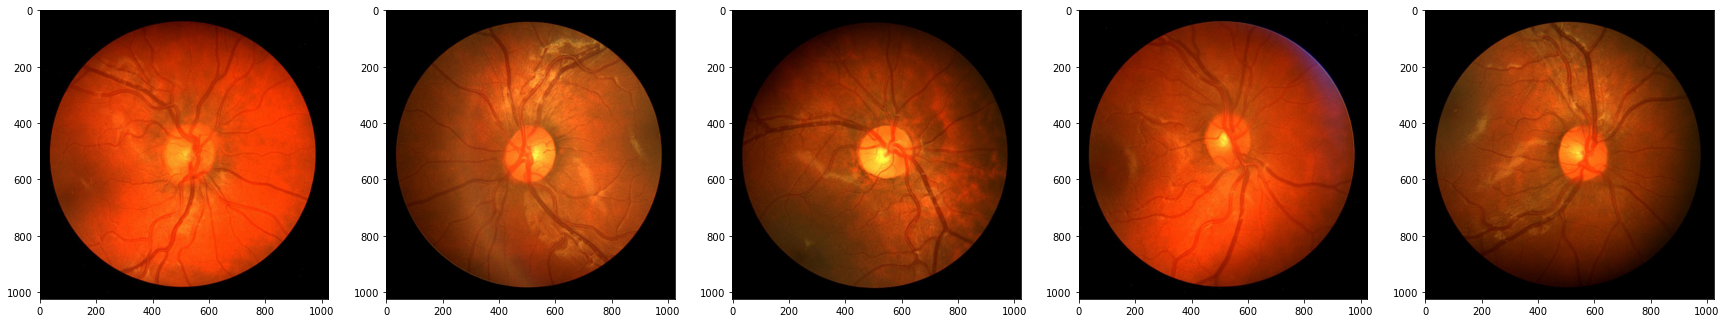

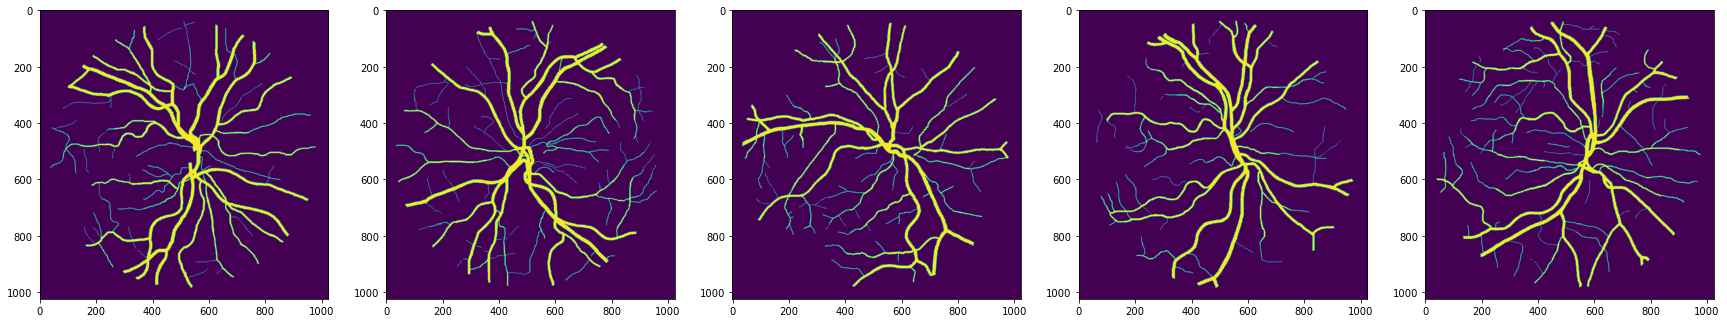

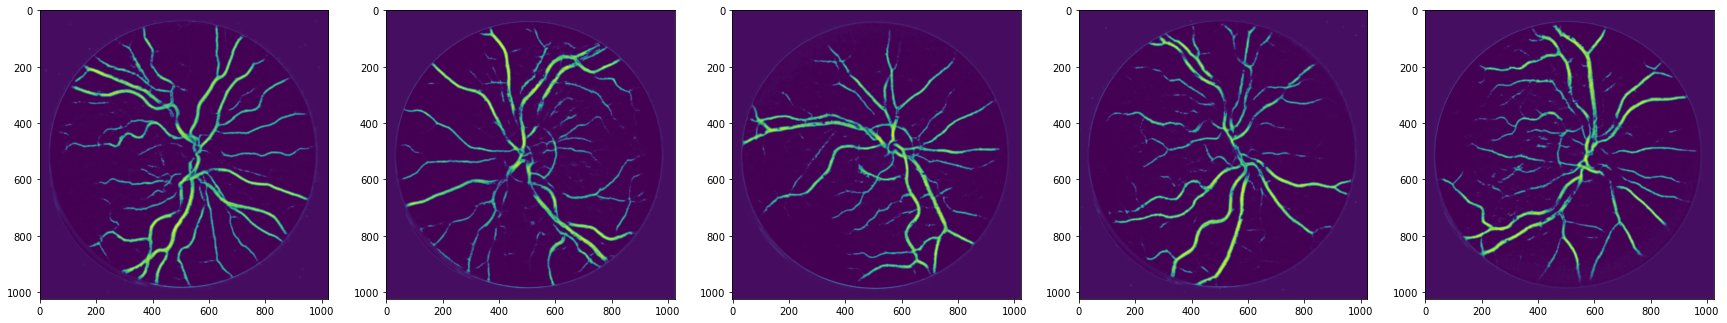

In [20]:
nplot = 5

fig = plt.figure(figsize=(30,10))
for count in range(1,nplot+1):
    ax = fig.add_subplot(1,nplot,count)
    ax.imshow(x_validate[count])

fig = plt.figure(figsize=(30,10))
for count in range(1,nplot+1):
    ax = fig.add_subplot(1,nplot,count)
    ax.imshow(y_validate[count])
    
fig = plt.figure(figsize=(30,10))
for count in range(1,nplot+1):
    ax = fig.add_subplot(1,nplot,count)
    ax.imshow(gen_mask[count])
    
plt.show()